## About this project

This is the first project that I'll be participating in Kaggle's competition and completing the challenge. By the end of this project, I'll fufill the expected output of the challenge and submit my work to the competition.

## Metadata

Data source: https://www.kaggle.com/competitions/llm-detect-ai-generated-text

## Prerequisite libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Load the data

In [2]:
training_df = pd.read_csv("../data/train_essays.csv")
training_df.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [3]:
training_df.shape

(1378, 4)

In [4]:
training_prompt = pd.read_csv("../data/train_prompts.csv")
training_prompt.head()

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [5]:
testing_df = pd.read_csv("../data/test_essays.csv")
testing_df.head()

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


## Understand the data

In [6]:
training_prompt.instructions.loc[0]

'Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage. Your essay must be based on ideas and information that can be found in the passage set. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your essay in the space provided.'

In [7]:
training_prompt.instructions.loc[1]

'Write a letter to your state senator in which you argue in favor of keeping the Electoral College or changing to election by popular vote for the president of the United States. Use the information from the texts in your essay. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to include a claim; address counterclaims; use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your response in the space provided.'

In [8]:
training_prompt.source_text.loc[0]

'# In German Suburb, Life Goes On Without Cars by Elisabeth Rosenthal\n\n1 VAUBAN, Germany—Residents of this upscale community are suburban pioneers, going where few soccer moms or commuting executives have ever gone before: they have given up their cars.\n\n2 Street parking, driveways and home garages are generally forbidden in this experimental new district on the outskirts of Freiburg, near the French and Swiss borders. Vauban’s streets are completely “car-free”—except the main thoroughfare, where the tram to downtown Freiburg runs, and a few streets on one edge of the community. Car ownership is allowed, but there are only two places to park—large garages at the edge of the development, where a car-owner buys a space, for $40,000, along with a home.\n\n3 As a result, 70 percent of Vauban’s families do not own cars, and 57 percent sold a car to move here. “When I had a car I was always tense. I’m much happier this way,” said Heidrun Walter, a media trainer and mother of two, as she 

According to the instructions in "training_prompt" and dataset description of the competition, student's responses must include the information, ideas and evidences from multiple provided source texts while those of LLM may or may not => Student's paragraphs will have closer similarity to the source texts, AI's generated texts may be less similar or totally different (if sources are not provided, LLM may generate some new ideas and information that are not related to the provided sources)

## Data Preprocessing

### Check missing data

In [9]:
training_df.isnull().sum()

id           0
prompt_id    0
text         0
generated    0
dtype: int64

### Check duplicates

In [10]:
training_df[training_df.duplicated()]

,id,prompt_id,text,generated


### Check format

In [11]:
training_df.prompt_id.unique()

array([0, 1], dtype=int64)

In [12]:
training_df.generated.unique()

array([0, 1], dtype=int64)

### Tokenization

In [13]:
X = training_df.text
y = training_df.generated

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 200000
max_sequence_len = 50
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X)

sequences = tokenizer.texts_to_sequences(X)
X_tokenized = pad_sequences(sequences, maxlen=max_sequence_len)

In [15]:
X_tokenized

array([[ 181,   56,   27, ...,  232,    3,   75],
       [ 119,   94, 5232, ...,    6,   58,  887],
       [1667,    6,  761, ...,  255,   10,  183],
       ...,
       [   3,  110,   35, ..., 1624,  368,  860],
       [  89,   57,   24, ..., 1921,    3,   62],
       [   3,   15, 1737, ...,   39, 1218,  637]])

### Check class balance

In [16]:
y.value_counts()

generated
0    1375
1       3
Name: count, dtype: int64

In [17]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy="minority", k_neighbors=2, random_state=10)
X_res, y_res = sm.fit_resample(X_tokenized, y)

In [18]:
y_res.value_counts()

generated
0    1375
1    1375
Name: count, dtype: int64

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_res)
X_scaled

array([[1.08603325e-02, 3.22677024e-03, 1.50656864e-03, ...,
        1.37881422e-02, 6.13271189e-05, 4.34205765e-03],
       [7.09865308e-03, 5.49746041e-03, 3.15174159e-01, ...,
        2.39793777e-04, 3.43431866e-03, 5.33108190e-02],
       [1.01019294e-01, 2.39020018e-04, 4.57394239e-02, ...,
        1.51669564e-02, 4.90616951e-04, 1.08551441e-02],
       ...,
       [1.45613396e-03, 7.58291007e-02, 6.02627456e-04, ...,
        2.13416462e-02, 2.14644916e-03, 3.00325654e-02],
       [2.91226793e-03, 3.58530027e-04, 7.23152947e-04, ...,
        4.49613333e-03, 1.59450509e-03, 4.46267037e-03],
       [4.36840189e-03, 1.33970720e-01, 2.10919609e-03, ...,
        2.93147893e-02, 6.13271189e-04, 5.14413219e-02]])

### Split data into training and testing sets

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=10, stratify=y_res)

## Model building

### Training

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.regularizers import l2

embedding_dim = 20

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_len))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_regularizer=l2(0.01))))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

model.compile(
    optimizer = Adam(learning_rate=4e-4, clipnorm=1.0),
    loss = BinaryCrossentropy(),
    metrics = Accuracy()
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 20)            4000000   
                                                                 
 bidirectional (Bidirection  (None, 64)                13568     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 4013633 (15.31 MB)
Trainable params: 4013633 (15.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/20

35/35 [==============================] - 10s 108ms/step - loss: 1.3311 - accuracy: 0.0000e+00 - val_loss: 1.2621 - val_accuracy: 0.0000e+00
Epoch 2/20
35/35 [==============================] - 3s 84ms/step - loss: 1.2066 - accuracy: 0.0000e+00 - val_loss: 1.1502 - val_accuracy: 0.0000e+00
Epoch 3/20
35/35 [==============================] - 3s 82ms/step - loss: 1.1042 - accuracy: 0.0000e+00 - val_loss: 1.0581 - val_accuracy: 0.0000e+00
Epoch 4/20
35/35 [==============================] - 3s 78ms/step - loss: 1.0170 - accuracy: 0.0000e+00 - val_loss: 0.9702 - val_accuracy: 0.0000e+00
Epoch 5/20
35/35 [==============================] - 3s 83ms/step - loss: 14.5782 - accuracy: 0.2395 - val_loss: 2.1030 - val_accuracy: 0.5236
Epoch 6/20
35/35 [==============================] - 3s 77ms/step - loss: 5.4565 - accuracy: 0.6714 - val_loss: 38.1127 - val_accuracy: 0.7527
Epoch 7/20
35/35 [==============================] - 3s 77ms/step - loss: 2.1402 - accuracy: 0.8555 - val_loss: 9.3107

### Evaluation

In [23]:
y_pred = (model.predict(X_test) > 0.5).astype(int)
y_pred

18/18 [==============================] - 1s 9ms/step


array([[1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
    

In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       267
           1       0.97      0.94      0.96       283

    accuracy                           0.96       550
   macro avg       0.96      0.96      0.96       550
weighted avg       0.96      0.96      0.96       550



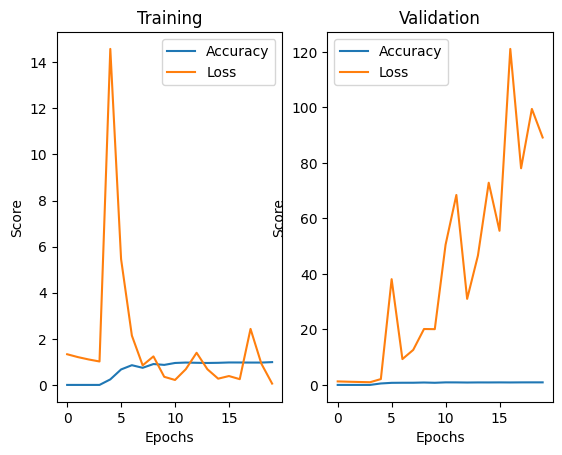

In [25]:
training_acc = history.history['accuracy']
training_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(training_acc, label='Accuracy')
ax1.plot(training_loss, label='Loss')
ax1.set_title('Training')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Score')
ax1.legend()

ax2.plot(val_acc, label='Accuracy')
ax2.plot(val_loss, label='Loss')
ax2.set_title('Validation')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Score')
ax2.legend()

plt.show()

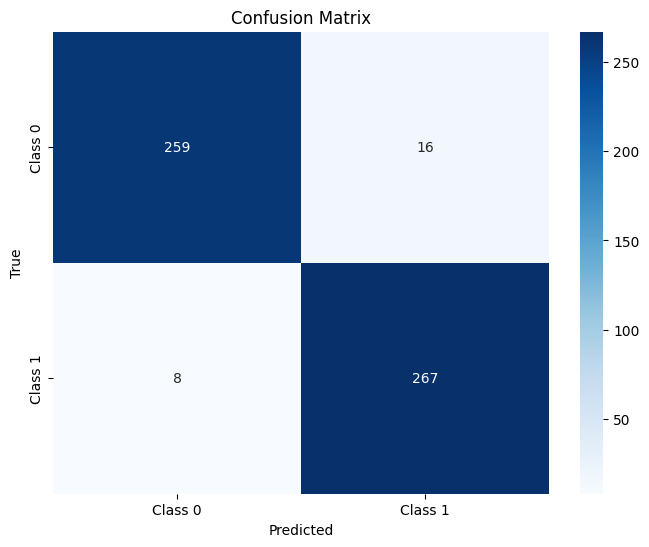

In [26]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Preprocessing automation

In [34]:
def input_preprocessing(df):
    # Drop null values (lacking even one of the three features is considered useless data anyway)
    df.dropna(inplace=True)
    # Extract features
    X = df.text
    # Tokenization
    tokenizer = Tokenizer(num_words=200000, oov_token="<OOV>")
    tokenizer.fit_on_texts(X)
    sequences = tokenizer.texts_to_sequences(X)
    X_tokenized = pad_sequences(sequences, maxlen=50)
    return X_tokenized

## Export model

In [35]:
model.save('../model/LSTM.h5')

## Submission

In [36]:
inputs = input_preprocessing(testing_df)
inputs

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 5, 3, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 3, 2, 4],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 2, 4, 6]])

In [30]:
from tensorflow.keras.models import load_model

# Load the model
LSTM = load_model('../model/LSTM.h5')
outputs = LSTM.predict(inputs)
outputs

1/1 [==============================] - 1s 571ms/step


array([[0.],
       [0.],
       [0.]], dtype=float32)

In [55]:
submission = pd.DataFrame([testing_df.id, outputs.reshape(-1)]).T
submission.columns = ["id", "generated"]
submission["generated"] = submission.generated.apply(lambda value: round(value, 1))

In [56]:
submission

,id,generated
0,0000aaaa,0.0
1,1111bbbb,0.0
2,2222cccc,0.0


In [57]:
submission.to_csv("../submission/submission.csv", index=False)